<a href="https://colab.research.google.com/github/sigvehaug/MLwPython/blob/master/NST_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GPU is about 15 times faster.
Optimal number of pixels is 60 or more per centimeter.
1x2 m2 = 6000 x 12000 = 72 MP
Best 2020 cameras go up to 60 MP

# Evening Lecture on Neural Style Transformation

Why not use a convolutional neural network to redraw an image in a different art style?




In [ ]:
# Import the content and style image
# Alternative 1: interactively now
#from google.colab import files
#files.upload()
# Alternative 2: get them from your google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configure the transformation
import keras
#keras.__version__
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
iterations = 10

# This is the path to the image you want to transform.
target_image_path = '/content/drive/MyDrive/Colab_Notebooks/NST/ai-feg.jpg'
#'/content/drive/MyDrive/Colab_Notebooks/NST/WorldOrigin.jpg'

# This is the path to the style image.
style_reference_image_path = '/content/drive/MyDrive/Colab_Notebooks/NST/scream.jpg'

#'/content/drive/MyDrive/Colab_Notebooks/NST/cubic.png'


# Dimensions of the generated picture.
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)


In [ ]:
# Helper functions
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def content_loss(base, combination):
    return K.sum(K.square(combination - base))

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [ ]:

from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# We build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')



# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'block5_conv2'
# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# Weights in the weighted average of the loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(style_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)
loss

# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

evaluator = Evaluator()

from scipy.optimize import fmin_l_bfgs_b
from matplotlib import pyplot as plt
import time

result_prefix = target_image_path.split()[0]
#iterations = 20

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_%d.png' % i
    if i == iterations -1 :
      plt.imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))


Model loaded.
Start of iteration 0
Current loss value: 10043.982
Image saved as /content/drive/MyDrive/Colab_Notebooks/NST/ai-feg.jpg_0.png
Iteration 0 completed in 11s
Start of iteration 1
Current loss value: 5518.204
Image saved as /content/drive/MyDrive/Colab_Notebooks/NST/ai-feg.jpg_1.png
Iteration 1 completed in 11s
Start of iteration 2
Current loss value: 4348.3364
Image saved as /content/drive/MyDrive/Colab_Notebooks/NST/ai-feg.jpg_2.png
Iteration 2 completed in 11s
Start of iteration 3
Current loss value: 3766.2988
Image saved as /content/drive/MyDrive/Colab_Notebooks/NST/ai-feg.jpg_3.png
Iteration 3 completed in 11s
Start of iteration 4
Current loss value: 3412.681
Image saved as /content/drive/MyDrive/Colab_Notebooks/NST/ai-feg.jpg_4.png
Iteration 4 completed in 11s
Start of iteration 5
Current loss value: 3164.89
Image saved as /content/drive/MyDrive/Colab_Notebooks/NST/ai-feg.jpg_5.png
Iteration 5 completed in 11s
Start of iteration 6
Current loss value: 2977.9949
Image sav

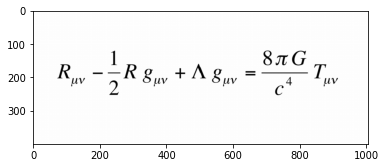

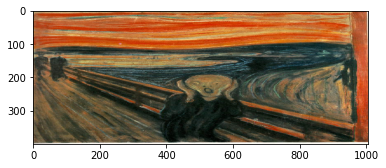

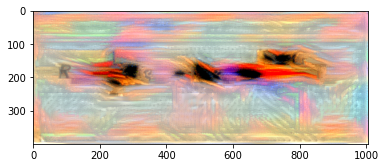

In [ ]:
from matplotlib import pyplot as plt

# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()
# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Generate image
plt.imshow(img)
plt.show()